## Mini Project III

In [452]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import plotly.express as px

import copy
import seaborn as sns
import os
from scipy import stats
import datetime
from pyclustertend import hopkins

import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

#### plot elbow graph

In [264]:
# elbow rule
def plot_distortion(X,label,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o', label = label)
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.legend()

#### silhouette function to check elbow

In [265]:
#silhouette score needs cluster from 1 to 9
def silhouette(X,max_clusters = 9):
    distortions = []
    
    for i in range(2, max_clusters +1):
        
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=0).fit(X)
        
        labels = km.labels_
        
        distortions.append((i,metrics.silhouette_score(X, labels, metric='euclidean')))

    return(distortions)

#### function to plot kmeans plot

In [266]:
 def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        
        #print(cluster)
        #print(y_res == cluster)
        
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=100,
                    marker='.',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='black',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

# 1) Twm-customer

In [757]:
twm_customer = pd.read_csv('twm_customer.csv', sep = ';', header = 0)

In [758]:
# 747 rows x 15 columns
# no Nan
twm_customer

,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,8298,Second ...,89194,Las Vegas,NV
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,10603,Daffodil ...,90159,Los Angeles,CA
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,8817,Figueroa ...,90024,Los Angeles,CA
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,676,Humble ...,90172,Los Angeles,CA
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,6578,C ...,10138,New York City,NY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,1363324,14795,36,6,1,F,4,,Lillian ...,Kaufman ...,9677,B ...,90016,Los Angeles,CA
743,1362895,26387,56,6,1,M,2,,Marty ...,McSherry ...,3227,Inspiration ...,10126,New York City,NY
744,1362569,61300,50,0,2,M,2,,Ken ...,Lawrence ...,6082,23rd ...,87194,Albuquerque,NM
745,1363364,15100,37,7,0,F,2,,Debbie ...,Runner ...,7851,H ...,35241,Birmingham,AL


In [557]:
twm_customer = twm_customer.drop(['cust_id', 'first_name', 'last_name', 'street_nbr','street_name','postal_code','city_name', 'name_prefix'], axis = 1)

<AxesSubplot:xlabel='years_with_bank', ylabel='count'>

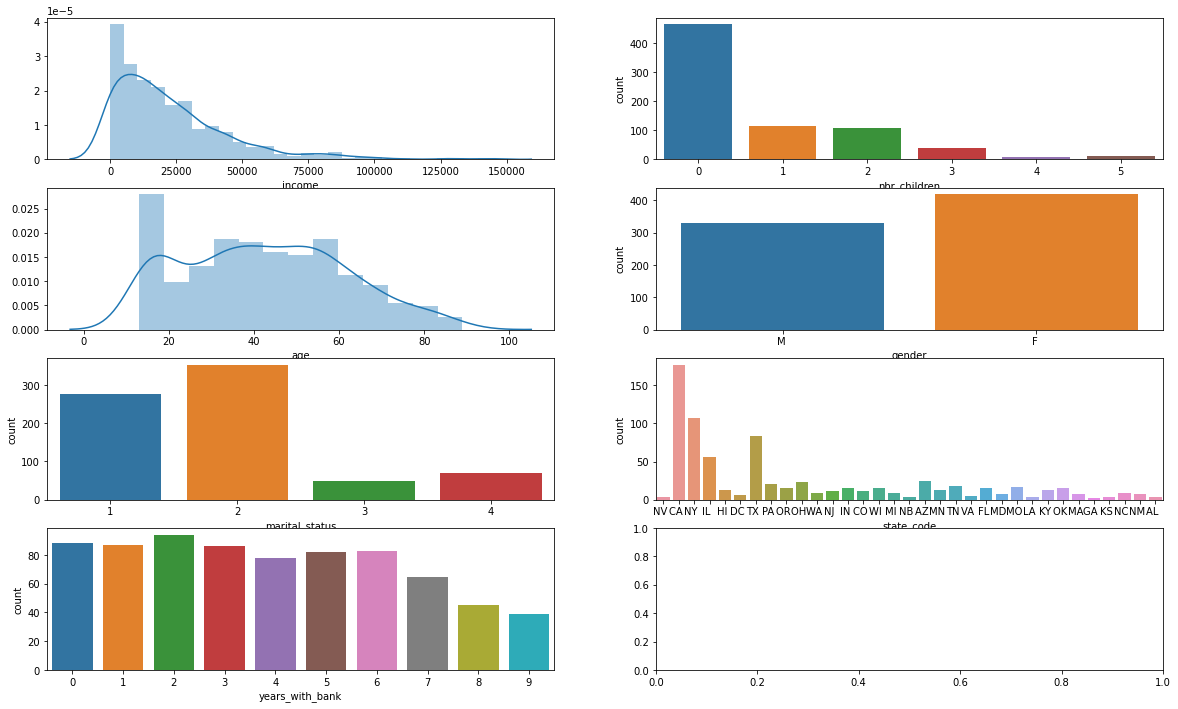

In [381]:
fig, ax = plt.subplots(4,2, figsize=(20,12))

sns.distplot(twm_customer['income'], ax = ax[0][0])
sns.countplot(twm_customer['nbr_children'], ax = ax[0][1])
sns.distplot(twm_customer['age'], ax = ax[1][0])
sns.countplot(twm_customer['gender'], ax = ax[1][1])
sns.countplot(twm_customer['marital_status'], ax = ax[2][0])
sns.countplot(twm_customer['state_code'], ax = ax[2][1])
sns.countplot(twm_customer['years_with_bank'], ax = ax[3][0])

# Feature engineering

In [559]:
twm_customer['state_code'] = twm_customer['state_code'].str.strip()
twm_customer['gender'] = twm_customer['gender'].str.strip()

### States to regions

In [560]:
# Creating regions for states
west = ['WA','MT', 'OR','ID', 'WY','CO', 'NM', 'UT', 'AZ','NV', 'CA', 'HI']
mid_west =['ND','SD', 'MN', 'IA', 'NB', 'KS', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH']
south = ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'KY', 'TN', 'GA','FL','SC', 'NC', 'VA', 'WV', 'DC','MD','DE']
north_east = ['PA', 'NY', 'NJ', 'CT', 'RI', 'MA', 'NH', 'VT', 'ME']

In [561]:
# 0 = west, 1 = mid_west, 2 = south, 3 = north_east
twm_FE = twm_customer
twm_FE['region'] = np.where(np.isin(twm_customer['state_code'],west),0,twm_customer['state_code'])
twm_FE['region'] = np.where(np.isin(twm_customer['state_code'],mid_west),1,twm_customer['region'])
twm_FE['region'] = np.where(np.isin(twm_customer['state_code'],south),2,twm_customer['region'])
twm_FE['region'] = np.where(np.isin(twm_customer['state_code'],north_east),3,twm_customer['region'])

### grouping number of children

In [562]:
# 0 = no kids, 1 = have kids
twm_FE['children'] = np.where(twm_FE['nbr_children'] > 0,1,0)

### grouping Marital status

In [563]:
twm_FE['marital'] = np.where(twm_FE['marital_status'] > 2,3,twm_FE['marital_status'])

### grouping years with bank

In [564]:
# 0 = short, 1 = medium, 2 = long
twm_FE['yr_with_bank']= np.where(twm_FE['years_with_bank'] < 4,0,twm_FE['years_with_bank'])
twm_FE['yr_with_bank']= np.where((twm_FE['years_with_bank']) > 3 & (twm_FE['years_with_bank'] < 6),1,twm_FE['yr_with_bank'])
twm_FE['yr_with_bank']= np.where(twm_FE['years_with_bank'] > 5,2,twm_FE['yr_with_bank'])

### gender to binary 1,0

In [565]:
# 0 = M, 1=F
twm_FE['sex']= np.where(twm_FE['gender'] == 'M',0,1)

### dropping featured columns

In [566]:
# dropping columns that were groupoed
twm_FE= twm_FE.drop(['state_code','marital_status','years_with_bank', 'nbr_children', 'gender'], axis = 1)

<AxesSubplot:xlabel='yr_with_bank', ylabel='count'>

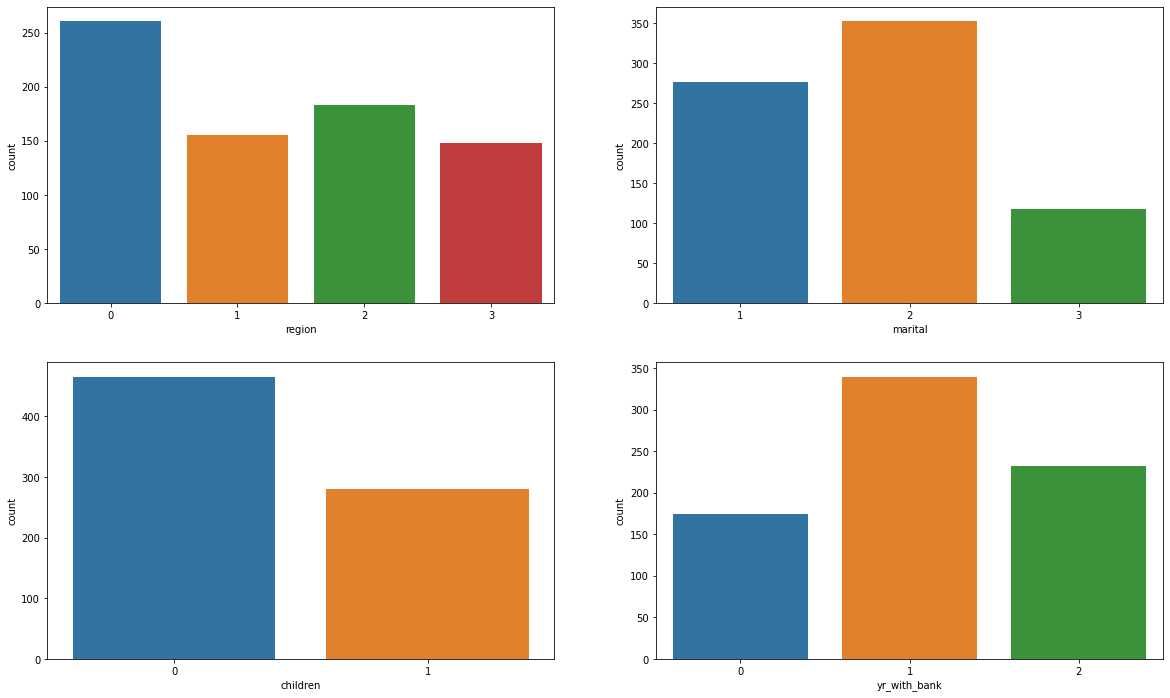

In [567]:
# plot to see result of FE
fig, ax = plt.subplots(2,2, figsize=(20,12))

sns.countplot(twm_FE['region'], ax = ax[0][0])
sns.countplot(twm_FE['marital'], ax = ax[0][1])
sns.countplot(twm_FE['children'], ax = ax[1][0])
sns.countplot(twm_FE['yr_with_bank'], ax = ax[1][1])

In [568]:
twm_FE.head()

,income,age,region,children,marital,yr_with_bank,sex
0,26150,46,0,1,2,1,0
1,6605,71,0,0,2,0,0
2,18548,38,0,0,1,2,1
3,47668,54,0,0,1,1,1
4,44554,59,3,1,3,2,1


### dropping high correlation features

In [392]:
col = ['income', 'age', 'region', 'children', 'marital','yr_with_bank', 'sex']

In [393]:
df_corr = twm_FE.corr().abs()
indices = np.where(df_corr > 0.8) 
indices = [(df_corr.index[x], df_corr.columns[y]) for x, y in zip(*indices) if x != y and x < y]

In [394]:
# no highly correlated features
for idx in indices: 
    try:
        twm_FE.drop(idx[1], axis = 1, inplace=True)
    except KeyError:
        pass

### Standardize numerical variables

In [395]:
twm_FE.head()

,income,age,region,children,marital,yr_with_bank,sex
0,26150,46,0,1,2,1,0
1,6605,71,0,0,2,0,0
2,18548,38,0,0,1,2,1
3,47668,54,0,0,1,1,1
4,44554,59,3,1,3,2,1


In [396]:
numerical = twm_FE[['income','age']].values
num_scaled = StandardScaler().fit_transform(numerical)
num_scaled

array([[ 0.1541846 ,  0.18431237],
       [-0.72652421,  1.49307037],
       [-0.18836584, -0.23449019],
       ...,
       [ 1.73806357,  0.39371365],
       [-0.34373468, -0.28684051],
       [-0.21869161, -1.28149658]])

In [397]:
twm_scaled = copy.deepcopy(twm_FE)
twm_scaled['age_scaled'] = num_scaled[:,1]
twm_scaled.drop(['income','age'], axis = 1, inplace= True)

## explore PCA

In [398]:
twm_scaled.head()

,region,children,marital,yr_with_bank,sex,age_scaled
0,0,1,2,1,0,0.184312
1,0,0,2,0,0,1.493070
2,0,0,1,2,1,-0.234490
3,0,0,1,1,1,0.603115
4,3,1,3,2,1,0.864867


In [288]:
pca = PCA(n_components=6)
pca.fit(twm_scaled)
twm_reduced = pca.fit_transform(twm_scaled)

In [289]:
# eigenvalues
pca.explained_variance_

array([1.32333508, 1.12915342, 0.55460849, 0.45457463, 0.24659579,
       0.10139303])

In [290]:
# total eigen values greater than 1 (2)
pca.explained_variance_[pca.explained_variance_>1]

array([1.32333508, 1.12915342])

In [291]:
# cumilitive variance explained
np.cumsum(pca.explained_variance_ratio_)

array([0.347363  , 0.64375514, 0.78933465, 0.90865621, 0.97338528,
       1.        ])

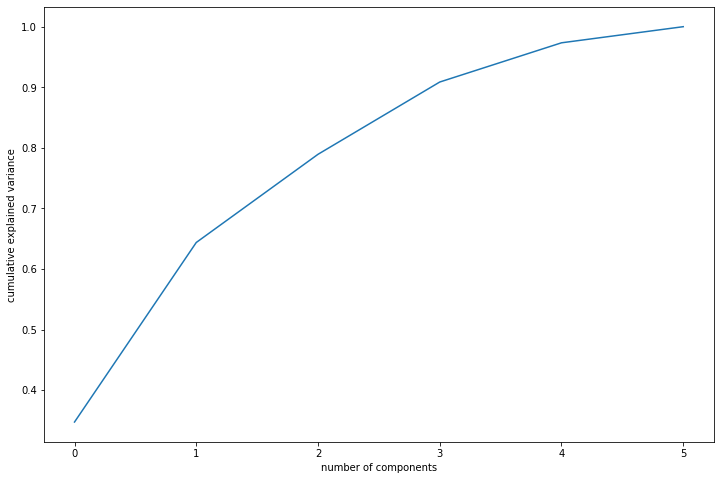

In [292]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance');

# PCA with 2 components

In [293]:
pca = PCA(n_components=2)
pca.fit(twm_scaled)
twm_reduced = pca.fit_transform(twm_scaled)

In [294]:
pca.explained_variance_

array([1.32333508, 1.12915342])

In [295]:
twm_PCA_df = pd.DataFrame(twm_reduced)
twm_PCA_df.columns = ['PC1','PC2']

In [296]:
twm_PCA_df

,PC1,PC2
0,-1.170194,0.633460
1,-0.793391,1.503123
2,-1.373833,-0.035300
3,-1.136392,0.512755
4,1.947950,0.960343
...,...,...
742,-1.256717,0.751310
743,1.839922,0.428816
744,-1.104312,0.644002
745,0.607302,-0.230227


# KMeans

In [297]:
twm_scaled['income'] = num_scaled[:,0]

In [298]:
twm_scaled

,region,children,marital,yr_with_bank,sex,age_scaled,income
0,0,1,2,1,0,0.184312,0.154185
1,0,0,2,0,0,1.493070,-0.726524
2,0,0,1,2,1,-0.234490,-0.188366
3,0,0,1,1,1,0.603115,1.123798
4,3,1,3,2,1,0.864867,0.983479
...,...,...,...,...,...,...,...
742,0,1,3,2,1,-0.339191,-0.357478
743,3,1,2,2,0,0.707816,0.164864
744,0,1,2,0,0,0.393714,1.738064
745,2,0,2,2,1,-0.286841,-0.343735


In [299]:
x_scale = twm_scaled.values

In [300]:
x_scale.shape

(747, 7)

In [301]:
y_scale.shape

(747,)

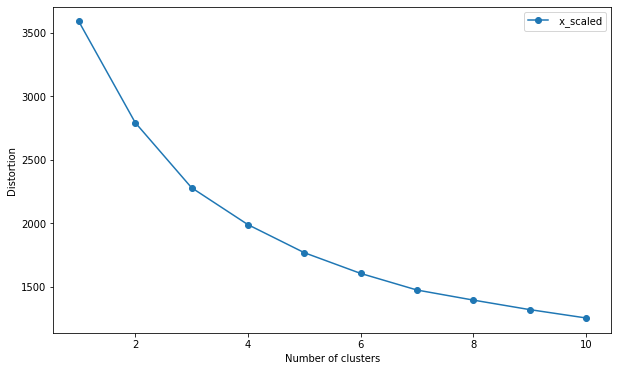

In [302]:
# elbow rule
fig, ax = plt.subplots(figsize=(10,6))
plot_distortion(x_scale,' x_scaled')

In [303]:
# silhouette score, want highest but at the same time considering the number of clusters
silhouette(x_scale)

[(2, 0.21875411486212587),
 (3, 0.2214429596876351),
 (4, 0.22133594596466866),
 (5, 0.21306335825218584),
 (6, 0.20849194573484614),
 (7, 0.21383387199395756),
 (8, 0.21993623842002377),
 (9, 0.2133257287794459)]

In [304]:
# Kmeans for age and income
KM = KMeans(n_clusters = 4)
y_res = KM.fit_predict(x_scale)

In [305]:
# appending cluster result to twm_PCA_df to plot
twm_PCA_df['clusters'] = y_res
#twm_PCA_df.drop('clusters',axis = 1, inplace= True)

In [306]:
twm_PCA_df

,PC1,PC2,clusters
0,-1.170194,0.633460,0
1,-0.793391,1.503123,0
2,-1.373833,-0.035300,0
3,-1.136392,0.512755,0
4,1.947950,0.960343,1
...,...,...,...
742,-1.256717,0.751310,0
743,1.839922,0.428816,1
744,-1.104312,0.644002,3
745,0.607302,-0.230227,1


0.2624881095825856


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

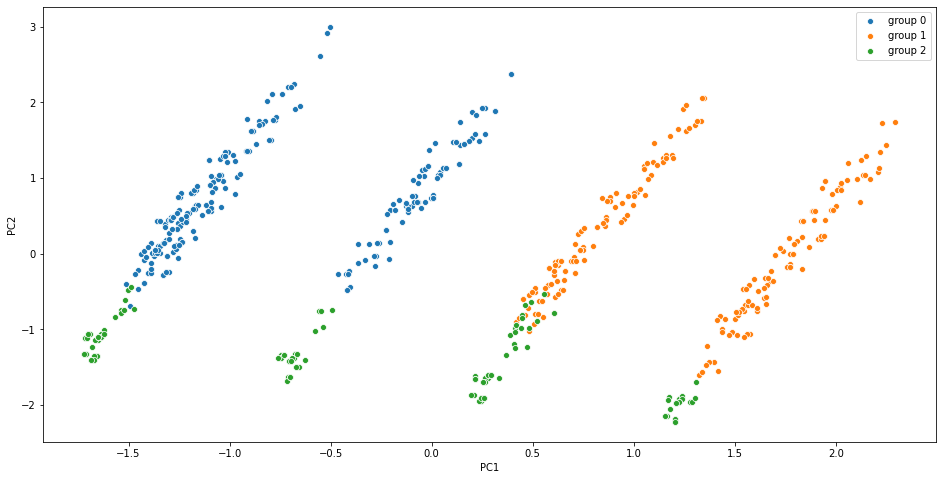

In [307]:
print(hopkins(x_scale,x_scale.shape[0]))

#plot clusters
fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(x="PC1", y="PC2", data=twm_PCA_df[twm_PCA_df['clusters']==0], label = 'group 0')
sns.scatterplot(x="PC1", y="PC2", data=twm_PCA_df[twm_PCA_df['clusters']==1], label = 'group 1')
sns.scatterplot(x="PC1", y="PC2", data=twm_PCA_df[twm_PCA_df['clusters']==2], label = 'group 2')
#sns.scatterplot(x="PC1", y="PC2", data=twm_PCA_df[twm_PCA_df['clusters']==3], label = 'group 3')

In [344]:
KM = KMeans(n_clusters = 4)
y_res = KM.fit_predict(x_scale)

In [345]:
twm_PCA_df['clusters'] = y_res

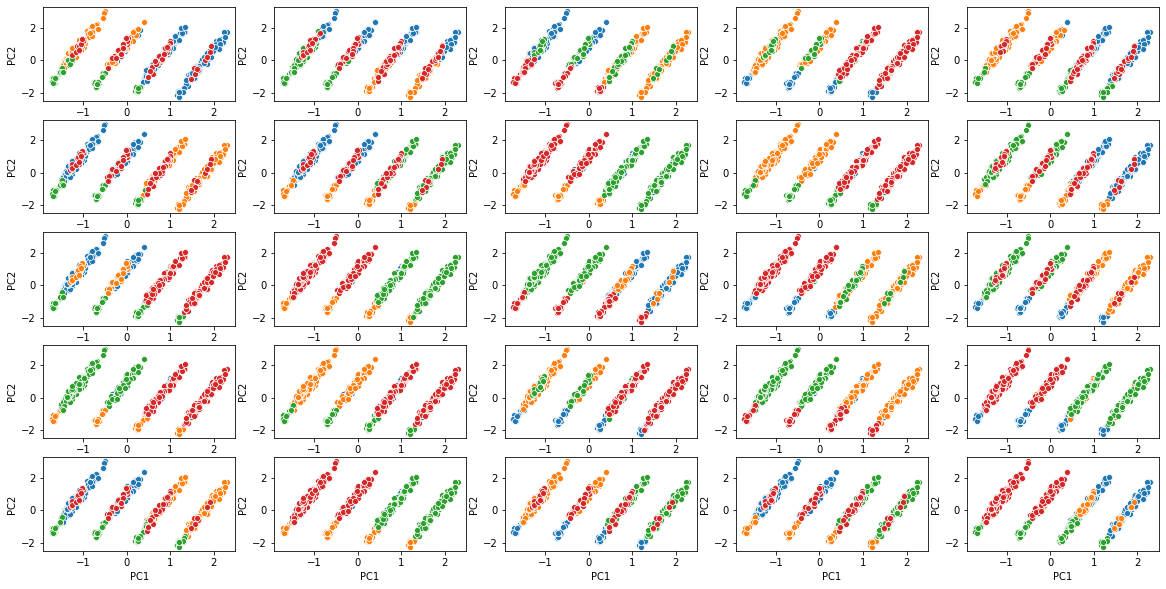

In [354]:
fig, ax = plt.subplots(5,5,figsize=(20,10))
row = 0
col = 0
for i in range(25):
    it = i + 1
    if col ==5:
        col = 0
        row += 1
    KM = KMeans(n_clusters = 4, max_iter=it)
    y_res = KM.fit_predict(x_scale)
    twm_PCA_df['clusters'] = y_res
    sns.scatterplot(x="PC1", y="PC2", data=twm_PCA_df[twm_PCA_df['clusters']==0],ax=ax[row][col])
    sns.scatterplot(x="PC1", y="PC2", data=twm_PCA_df[twm_PCA_df['clusters']==1],ax=ax[row][col])
    sns.scatterplot(x="PC1", y="PC2", data=twm_PCA_df[twm_PCA_df['clusters']==2],ax=ax[row][col])
    sns.scatterplot(x="PC1", y="PC2", data=twm_PCA_df[twm_PCA_df['clusters']==3],ax=ax[row][col])
    col += 1

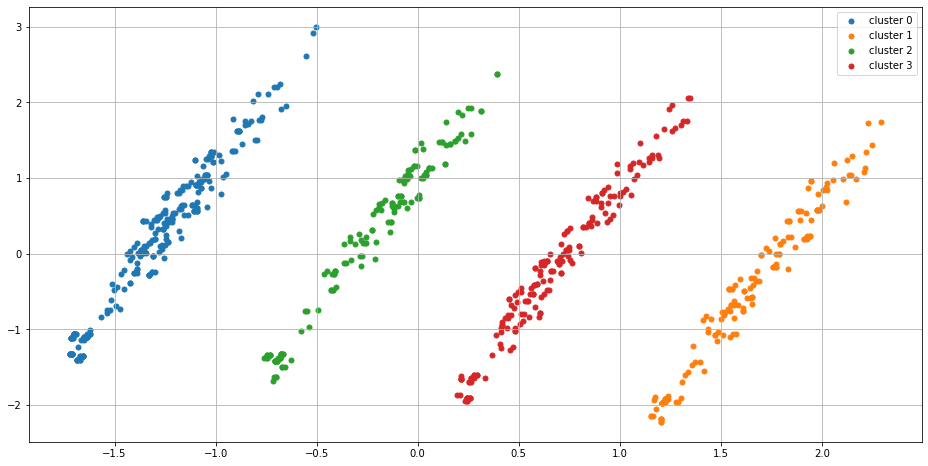

In [355]:
twm_DBSCAN =copy.deepcopy(twm_PCA_df)
twm_DBSCAN.drop('clusters', axis =1, inplace = True)
db = DBSCAN(eps = 0.5, min_samples = 5, metric= 'euclidean')
y_db = db.fit_predict(twm_DBSCAN.values)
fig, ax = plt.subplots(figsize=(16,8))
plot_clusters(twm_DBSCAN.values, y_db)

# Radar chart

In [1]:
twm_radar = twm_scaled
twm_radar['income'] = num_scaled[:,0]
twm_radar['cluster'] = y_res
twm_radar.head()

NameError: name 'twm_scaled' is not defined

In [312]:
categories = ['region', 'children', 'marital', 'yr_with_bank', 'sex', 'age_scaled','income']

In [313]:
group_0 = []
group_0.append(np.mean(twm_radar['region'][twm_radar['cluster'] == 0]))
group_0.append(np.mean(twm_radar['children'][twm_radar['cluster'] == 0]))
group_0.append(np.mean(twm_radar['marital'][twm_radar['cluster'] == 0]))
group_0.append(np.mean(twm_radar['yr_with_bank'][twm_radar['cluster'] == 0]))
group_0.append(np.mean(twm_radar['sex'][twm_radar['cluster'] == 0]))
group_0.append(np.mean(twm_radar['age_scaled'][twm_radar['cluster'] == 0]))
group_0.append(np.mean(twm_radar['income'][twm_radar['cluster'] == 0]))

In [314]:
group_1 = []
group_1.append(np.mean(twm_radar['region'][twm_radar['cluster'] == 1]))
group_1.append(np.mean(twm_radar['children'][twm_radar['cluster'] == 1]))
group_1.append(np.mean(twm_radar['marital'][twm_radar['cluster'] == 1]))
group_1.append(np.mean(twm_radar['yr_with_bank'][twm_radar['cluster'] == 1]))
group_1.append(np.mean(twm_radar['sex'][twm_radar['cluster'] == 1]))
group_1.append(np.mean(twm_radar['age_scaled'][twm_radar['cluster'] == 1]))
group_1.append(np.mean(twm_radar['income'][twm_radar['cluster'] == 1]))

In [315]:
group_2 = []
group_2.append(np.mean(twm_radar['region'][twm_radar['cluster'] == 2]))
group_2.append(np.mean(twm_radar['children'][twm_radar['cluster'] == 2]))
group_2.append(np.mean(twm_radar['marital'][twm_radar['cluster'] == 2]))
group_2.append(np.mean(twm_radar['yr_with_bank'][twm_radar['cluster'] == 2]))
group_2.append(np.mean(twm_radar['sex'][twm_radar['cluster'] == 2]))
group_2.append(np.mean(twm_radar['age_scaled'][twm_radar['cluster'] == 2]))
group_2.append(np.mean(twm_radar['income'][twm_radar['cluster'] == 2]))

In [316]:
group_3 = []
group_3.append(np.mean(twm_radar['region'][twm_radar['cluster'] == 3]))
group_3.append(np.mean(twm_radar['children'][twm_radar['cluster'] == 3]))
group_3.append(np.mean(twm_radar['marital'][twm_radar['cluster'] == 3]))
group_3.append(np.mean(twm_radar['yr_with_bank'][twm_radar['cluster'] == 3]))
group_3.append(np.mean(twm_radar['sex'][twm_radar['cluster'] == 3]))
group_3.append(np.mean(twm_radar['age_scaled'][twm_radar['cluster'] == 3]))
group_3.append(np.mean(twm_radar['income'][twm_radar['cluster'] == 3]))

In [317]:
group_0_df = pd.DataFrame(dict(means= group_0, category = categories))
group_1_df = pd.DataFrame(dict(means= group_1, category = categories))
group_2_df = pd.DataFrame(dict(means= group_2, category = categories))
group_3_df = pd.DataFrame(dict(means= group_3, category = categories))

In [318]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=group_0_df['means'],theta=group_0_df['category'],fill='toself',name='group 0'))

fig.add_trace(go.Scatterpolar(r=group_1_df['means'],theta=group_1_df['category'],fill='toself',name='group 1'))

fig.add_trace(go.Scatterpolar(r=group_2_df['means'],theta=group_2_df['category'],fill='toself',name='group 2'))

fig.add_trace(go.Scatterpolar(r=group_3_df['means'],theta=group_3_df['category'],fill='toself',name='group 3'))

fig.update_layout(
    autosize = False,
    width=800,
    height=800,
    polar=dict(
        radialaxis=dict(
          visible=True,
    )),
  showlegend=True
)

fig.show()

In [52]:
# group 3 (purple)
# high income

# grup 0 (blue)
# same as red but in east

#group 1 *red)
# same as blue but in west

#group 2 (green)
# low income and low age

# Kmeans with only 2 columns

<AxesSubplot:xlabel='nbr_children', ylabel='income'>

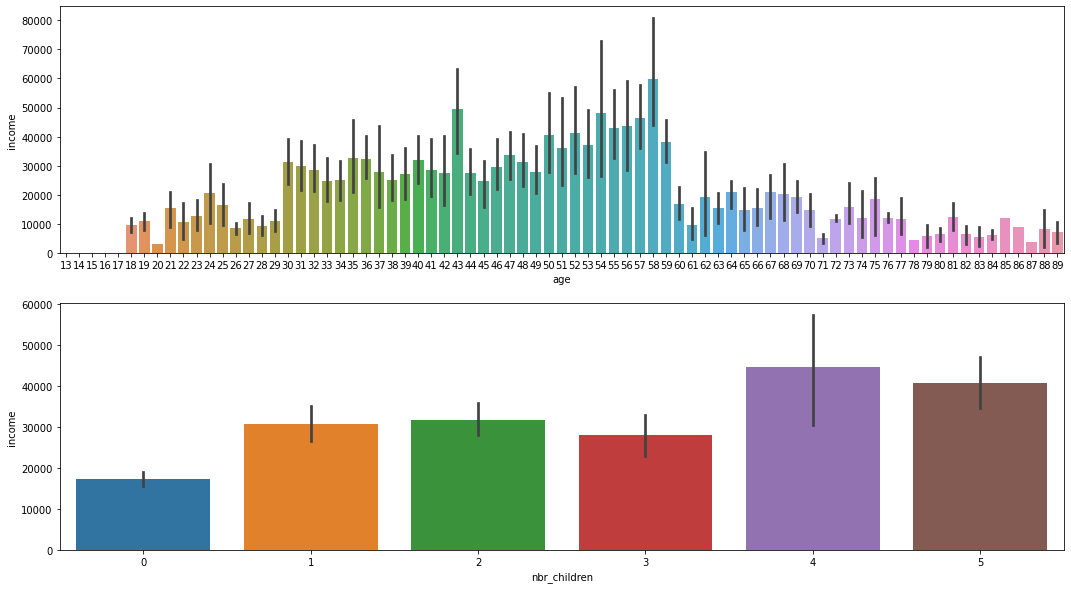

In [319]:
fig, ax = plt.subplots(2, figsize=(18,10))

sns.barplot(x="age", y="income", data=twm_customer, ax = ax[0])
sns.barplot(x='nbr_children', y="income", data=twm_customer, ax = ax[1])

In [321]:
twm_age = twm_customer[['age','income']] 
twm_kid = twm_customer[['nbr_children','income']]

scaler = StandardScaler()
scaler.fit(twm_age)
twm_age_scale = scaler.transform(twm_age)

scaler = StandardScaler()
scaler.fit(twm_kid)
twm_kid_scale = scaler.transform(twm_kid)


x_age_scale = twm_age_scale[:,0]
y_age_scale = twm_age_scale[:,1]

x_kid_scale = twm_kid_scale[:,0]
y_kid_scale = twm_kid_scale[:,1]

In [322]:
x_age_scale = x_age_scale.reshape(-1, 1)
x_kid_scale = x_kid_scale.reshape(-1, 1)

<ipython-input-264-8954a47aff68>:10: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.

<ipython-input-264-8954a47aff68>:10: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.

<ipython-input-264-8954a47aff68>:10: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.

<ipython-input-264-8954a47aff68>:10: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.



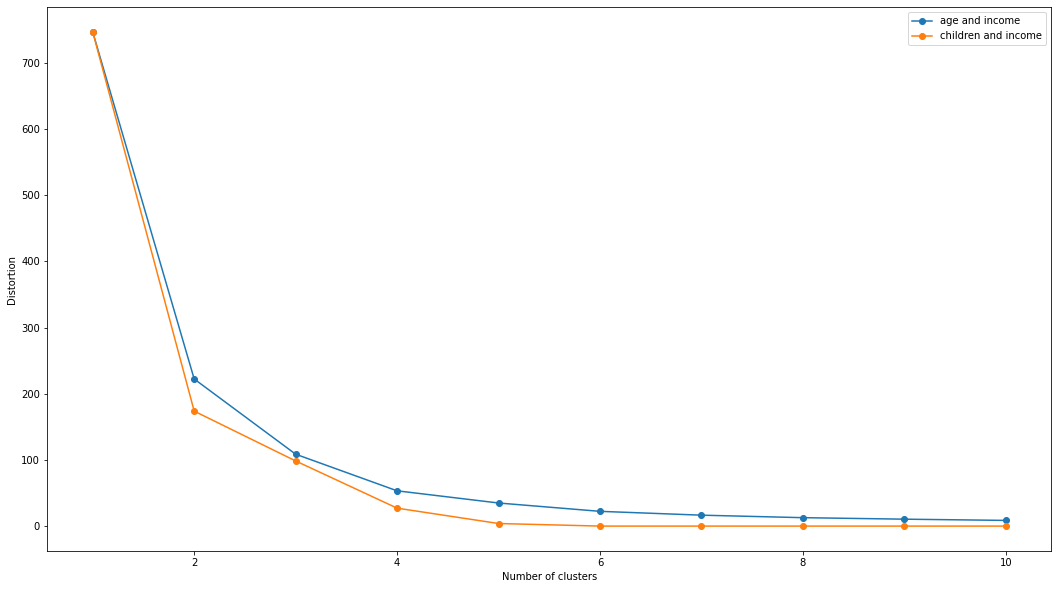

In [323]:
# Plotting elbow to determine number of clusters
fig, ax = plt.subplots(1,figsize=(18,10))

plot_distortion(x_age_scale, 'age and income')
plot_distortion(x_kid_scale, 'children and income')

In [325]:
# 4 clusters (highest silhouette)
silhouette(x_age_scale)

[(2, 0.5948156690339517),
 (3, 0.5500403953199883),
 (4, 0.5978882439467766),
 (5, 0.5802488354912299),
 (6, 0.5936264995087404),
 (7, 0.585947936515072),
 (8, 0.5827550468611097),
 (9, 0.5773938688648476)]

In [326]:
# say 4 for now :)
silhouette(x_kid_scale)

<ipython-input-265-90036d61ed79>:7: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.

<ipython-input-265-90036d61ed79>:7: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.

<ipython-input-265-90036d61ed79>:7: ConvergenceWarning:

Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.



[(2, 0.800509368307384),
 (3, 0.8875622973823004),
 (4, 0.9307144256744468),
 (5, 0.9899598393574297),
 (6, 1.0),
 (7, 1.0),
 (8, 1.0),
 (9, 1.0)]

# Kmeans

In [327]:
# Kmeans for age and income
KM = KMeans(n_clusters = 4)
y_age = KM.fit_predict(x_age_scale)
print('age and income:',KM.inertia_)

# Kmeans for age and income
KM = KMeans(n_clusters = 3)
y_kid = KM.fit_predict(x_kid_scale)
print('children and income:' ,KM.inertia_)

age and income: 53.313842692358314
children and income: 74.20756048968248


0.08797623262695112


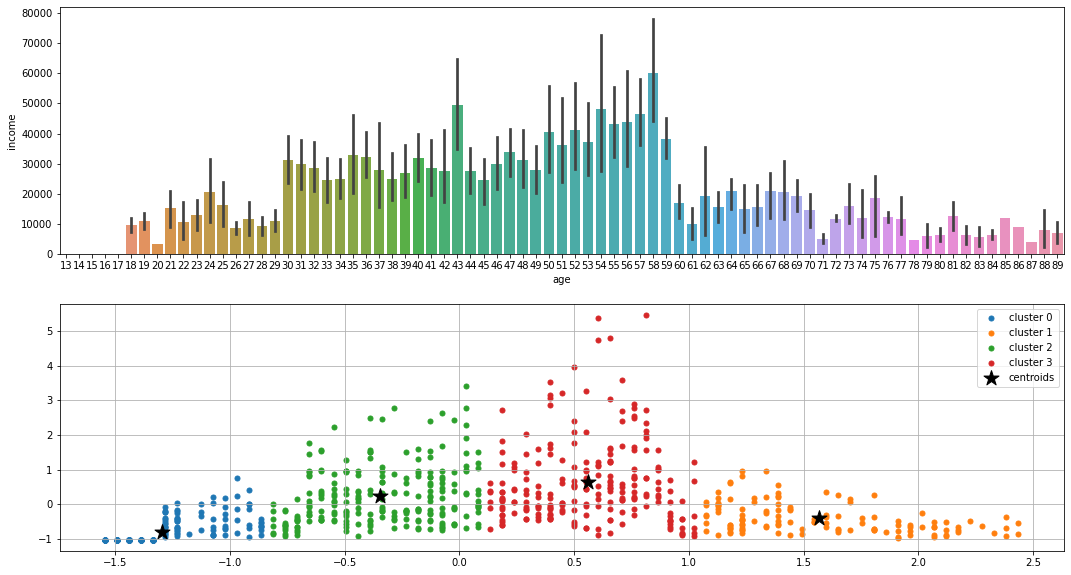

In [328]:
# hopkins test to see if cluster were meaningful
print(hopkins(twm_age_scale,twm_age_scale.shape[0]))

#plot clusters
fig, ax = plt.subplots(2,figsize=(18,10))
sns.barplot(x="age", y="income", data=twm_customer, ax = ax[0])
ax[1] = plot_clusters(twm_age_scale,y_age, plt_cluster_centers = True)

0.043151458351862675


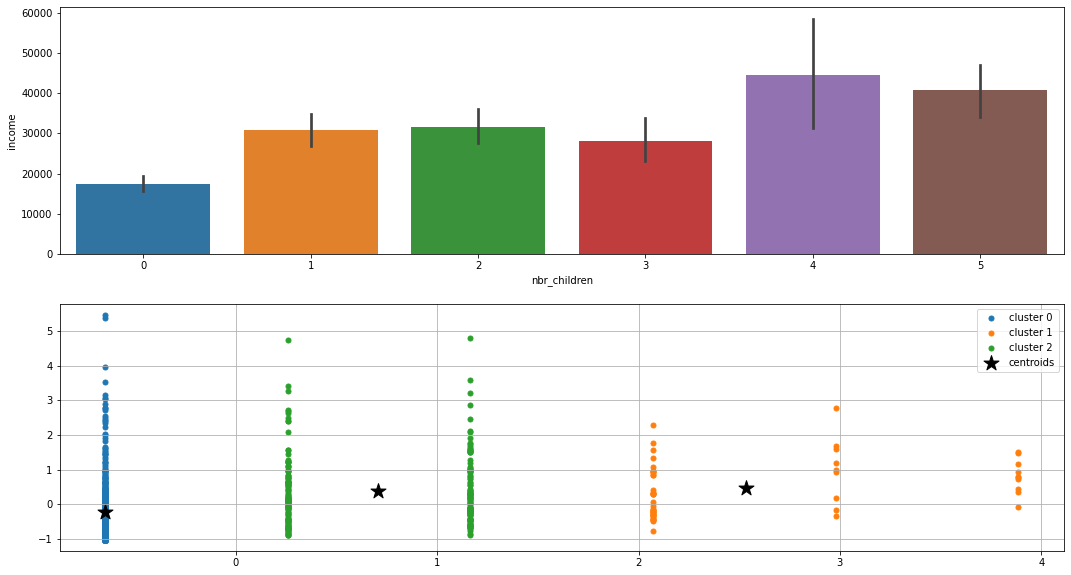

In [329]:
# hopkins test to see if cluster were meaningful
print(hopkins(twm_kid_scale,twm_kid_scale.shape[0]))

#plot clusters
fig, ax = plt.subplots(2,figsize=(18,10))
sns.barplot(x='nbr_children', y="income", data=twm_customer, ax = ax[0])
ax[1] = plot_clusters(twm_kid_scale,y_kid, plt_cluster_centers = True)

## Radar Chart

In [357]:
twm_customer_age = twm_customer

In [358]:
numerical = list(twm_customer_age.dtypes[twm_customer_age.dtypes != 'object'].index)
categorical = list(twm_customer_age.dtypes[twm_customer_age.dtypes == 'object'].index)

In [360]:
col =['cust_id', 'income', 'age', 'years_with_bank', 'nbr_children','marital_status', 'street_nbr', 'postal_code', 'y_age']
twm_customer_age_num = twm_customer_age[numerical]
twm_customer_age_num.head()

,income,age,years_with_bank,nbr_children,marital_status,children,marital,yr_with_bank,sex
0,26150,46,5,1,2,1,2,1,0
1,6605,71,1,0,2,0,2,0,0
2,18548,38,8,0,1,0,1,2,1
3,47668,54,3,0,1,0,1,1,1
4,44554,59,9,2,4,1,3,2,1


In [361]:
scaler = StandardScaler()
scaler.fit(twm_customer_age_num)
twm_customer_age_num = scaler.transform(twm_customer_age_num)

In [363]:
twm_customer_age_num = pd.DataFrame(twm_customer_age_num)
twm_customer_age_num.columns=col

In [364]:
twm_customer_age_num['y_age'] = y_age
twm_customer_age_num['y_kid'] = y_kid

In [365]:
group_0 = []
group_0.append(np.mean(twm_customer_age_num['income'][twm_customer_age_num['y_age'] == 0]))
group_0.append(np.mean(twm_customer_age_num['years_with_bank'][twm_customer_age_num['y_age'] == 0]))
group_0.append(np.mean(twm_customer_age_num['nbr_children'][twm_customer_age_num['y_age'] == 0]))
group_0.append(np.mean(twm_customer_age_num['marital_status'][twm_customer_age_num['y_age'] == 0]))

In [366]:
group_1 = []
group_1.append(np.mean(twm_customer_age_num['income'][twm_customer_age_num['y_age'] == 1]))
group_1.append(np.mean(twm_customer_age_num['years_with_bank'][twm_customer_age_num['y_age'] == 1]))
group_1.append(np.mean(twm_customer_age_num['nbr_children'][twm_customer_age_num['y_age'] == 1]))
group_1.append(np.mean(twm_customer_age_num['marital_status'][twm_customer_age_num['y_age'] == 1]))

In [367]:
group_2 = []
group_2.append(np.mean(twm_customer_age_num['income'][twm_customer_age_num['y_age'] == 2]))
group_2.append(np.mean(twm_customer_age_num['years_with_bank'][twm_customer_age_num['y_age'] == 2]))
group_2.append(np.mean(twm_customer_age_num['nbr_children'][twm_customer_age_num['y_age'] == 2]))
group_2.append(np.mean(twm_customer_age_num['marital_status'][twm_customer_age_num['y_age'] == 2]))

In [368]:
group_3 = []
group_3.append(np.mean(twm_customer_age_num['income'][twm_customer_age_num['y_age'] == 3]))
group_3.append(np.mean(twm_customer_age_num['years_with_bank'][twm_customer_age_num['y_age'] == 3]))
group_3.append(np.mean(twm_customer_age_num['nbr_children'][twm_customer_age_num['y_age'] == 3]))
group_3.append(np.mean(twm_customer_age_num['marital_status'][twm_customer_age_num['y_age'] == 3]))

In [369]:
group_0_df = pd.DataFrame(dict(means= group_0, category = categories))
group_1_df = pd.DataFrame(dict(means= group_1, category = categories))
group_2_df = pd.DataFrame(dict(means= group_2, category = categories))
group_3_df = pd.DataFrame(dict(means= group_3, category = categories))

In [370]:
categories = ['income','years_with_bank','nbr_children','marital_status']

In [371]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=group_0_df['means'],theta=group_0_df['category'],fill='toself',name='group 0'))

fig.add_trace(go.Scatterpolar(r=group_1_df['means'],theta=group_1_df['category'],fill='toself',name='group 1'))

fig.add_trace(go.Scatterpolar(r=group_2_df['means'],theta=group_2_df['category'],fill='toself',name='group 2'))

fig.add_trace(go.Scatterpolar(r=group_3_df['means'],theta=group_3_df['category'],fill='toself',name='group 3'))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=True
)

fig.show()

In [372]:
categories = ['income','years_with_bank','age','marital_status']

In [373]:
group_0 = []
group_0.append(np.mean(twm_customer_age_num['income'][twm_customer_age_num['y_kid'] == 0]))
group_0.append(np.mean(twm_customer_age_num['years_with_bank'][twm_customer_age_num['y_kid'] == 0]))
group_0.append(np.mean(twm_customer_age_num['age'][twm_customer_age_num['y_kid'] == 0]))
group_0.append(np.mean(twm_customer_age_num['marital_status'][twm_customer_age_num['y_kid'] == 0]))

In [374]:
group_1 = []
group_1.append(np.mean(twm_customer_age_num['income'][twm_customer_age_num['y_kid'] == 1]))
group_1.append(np.mean(twm_customer_age_num['years_with_bank'][twm_customer_age_num['y_kid'] == 1]))
group_1.append(np.mean(twm_customer_age_num['age'][twm_customer_age_num['y_kid'] == 1]))
group_1.append(np.mean(twm_customer_age_num['marital_status'][twm_customer_age_num['y_kid'] == 1]))

In [375]:
group_2 = []
group_2.append(np.mean(twm_customer_age_num['income'][twm_customer_age_num['y_kid'] == 2]))
group_2.append(np.mean(twm_customer_age_num['years_with_bank'][twm_customer_age_num['y_kid'] == 2]))
group_2.append(np.mean(twm_customer_age_num['age'][twm_customer_age_num['y_kid'] == 2]))
group_2.append(np.mean(twm_customer_age_num['marital_status'][twm_customer_age_num['y_kid'] == 2]))

In [376]:
group_0_df = pd.DataFrame(dict(means= group_0, category = categories))
group_1_df = pd.DataFrame(dict(means= group_1, category = categories))
group_2_df = pd.DataFrame(dict(means= group_2, category = categories))

In [377]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=group_0_df['means'],theta=group_0_df['category'],fill='toself',name='group 0'))

fig.add_trace(go.Scatterpolar(r=group_1_df['means'],theta=group_1_df['category'],fill='toself',name='group 1'))

fig.add_trace(go.Scatterpolar(r=group_2_df['means'],theta=group_2_df['category'],fill='toself',name='group 2'))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=True
)

fig.show()

# Regression

# Not scaled

In [670]:
credit_regression = pd.read_csv('credit_regression.csv') 
credit_regression.drop(['Unnamed: 0'], axis = 1, inplace = True)
credit_regression.head()

,income,credit_limit,credit_rating,starting_balance,ending_balance,new_balance,tran_time,abs_tran_amt,small_tran,large_tran
0,50890.0,2500.0,0.0,1607.40,20.00,-2270.140937,90762.718750,264.174375,13.0,19.0
1,10053.0,3000.0,0.0,1278.78,369.72,-274.873273,124236.781818,182.569636,41.0,14.0
2,22690.0,1100.0,0.0,282.38,1100.00,-691.661111,112049.388889,175.404861,58.0,14.0
3,6605.0,3000.0,0.0,0.00,1548.23,-793.345000,122657.656250,149.162813,28.0,4.0
4,55888.0,2800.0,0.0,1465.41,20.00,-2432.648000,109276.800000,397.074286,15.0,20.0


In [671]:
y = credit_regression['income']
x = credit_regression.drop('income', axis = 1)

In [672]:
lin_reg = sm.OLS(y,x)

In [673]:
model = lin_reg.fit()
print_model = model.summary()
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 income   R-squared (uncentered):                   0.804
Model:                            OLS   Adj. R-squared (uncentered):              0.800
Method:                 Least Squares   F-statistic:                              204.4
Date:                Fri, 14 Aug 2020   Prob (F-statistic):                   1.68e-152
Time:                        13:32:58   Log-Likelihood:                         -5038.7
No. Observations:                 457   AIC:                                  1.010e+04
Df Residuals:                     448   BIC:                                  1.013e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
credit_limit         1.2959      0.518      2.501      0.013       0.277       2.314
credit_rating     2889.7665    522.840      5.527      0.000    1862.244    3917.289
starting_balance     0.4529      0.613      0.739      0.460      -0.751       1.657
ending_balance      -0.9274      0.726     -1.278      0.202      -2.354       0.499
new_balance         -7.7694      0.895     -8.680      0.000      -9.528      -6.010
tran_time            0.1486      0.019      7.933      0.000       0.112       0.185
abs_tran_amt         2.8830      1.787      1.614      0.107      -0.629       6.395
small_tran        -422.8754     48.422     -8.733      0.000    -518.038    -327.713
large_tran         735.6800     87.644      8.394      0.000     563.435     907.925
==============================================================================
Omnibus:                       76.827   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              662.525
Skew:                           0.399   Prob(JB):                    1.36e-144
Kurtosis:                       8.844   Cond. No.                     8.15e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# checking regression assumptions

In [662]:
credit_regression = pd.read_csv('credit_regression.csv') 

In [612]:
credit_regression.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [613]:
credit_regression.head()

,income,credit_limit,credit_rating,starting_balance,ending_balance,new_balance,tran_time,abs_tran_amt,small_tran,large_tran
0,50890.0,2500.0,0.0,1607.40,20.00,-2270.140937,90762.718750,264.174375,13.0,19.0
1,10053.0,3000.0,0.0,1278.78,369.72,-274.873273,124236.781818,182.569636,41.0,14.0
2,22690.0,1100.0,0.0,282.38,1100.00,-691.661111,112049.388889,175.404861,58.0,14.0
3,6605.0,3000.0,0.0,0.00,1548.23,-793.345000,122657.656250,149.162813,28.0,4.0
4,55888.0,2800.0,0.0,1465.41,20.00,-2432.648000,109276.800000,397.074286,15.0,20.0


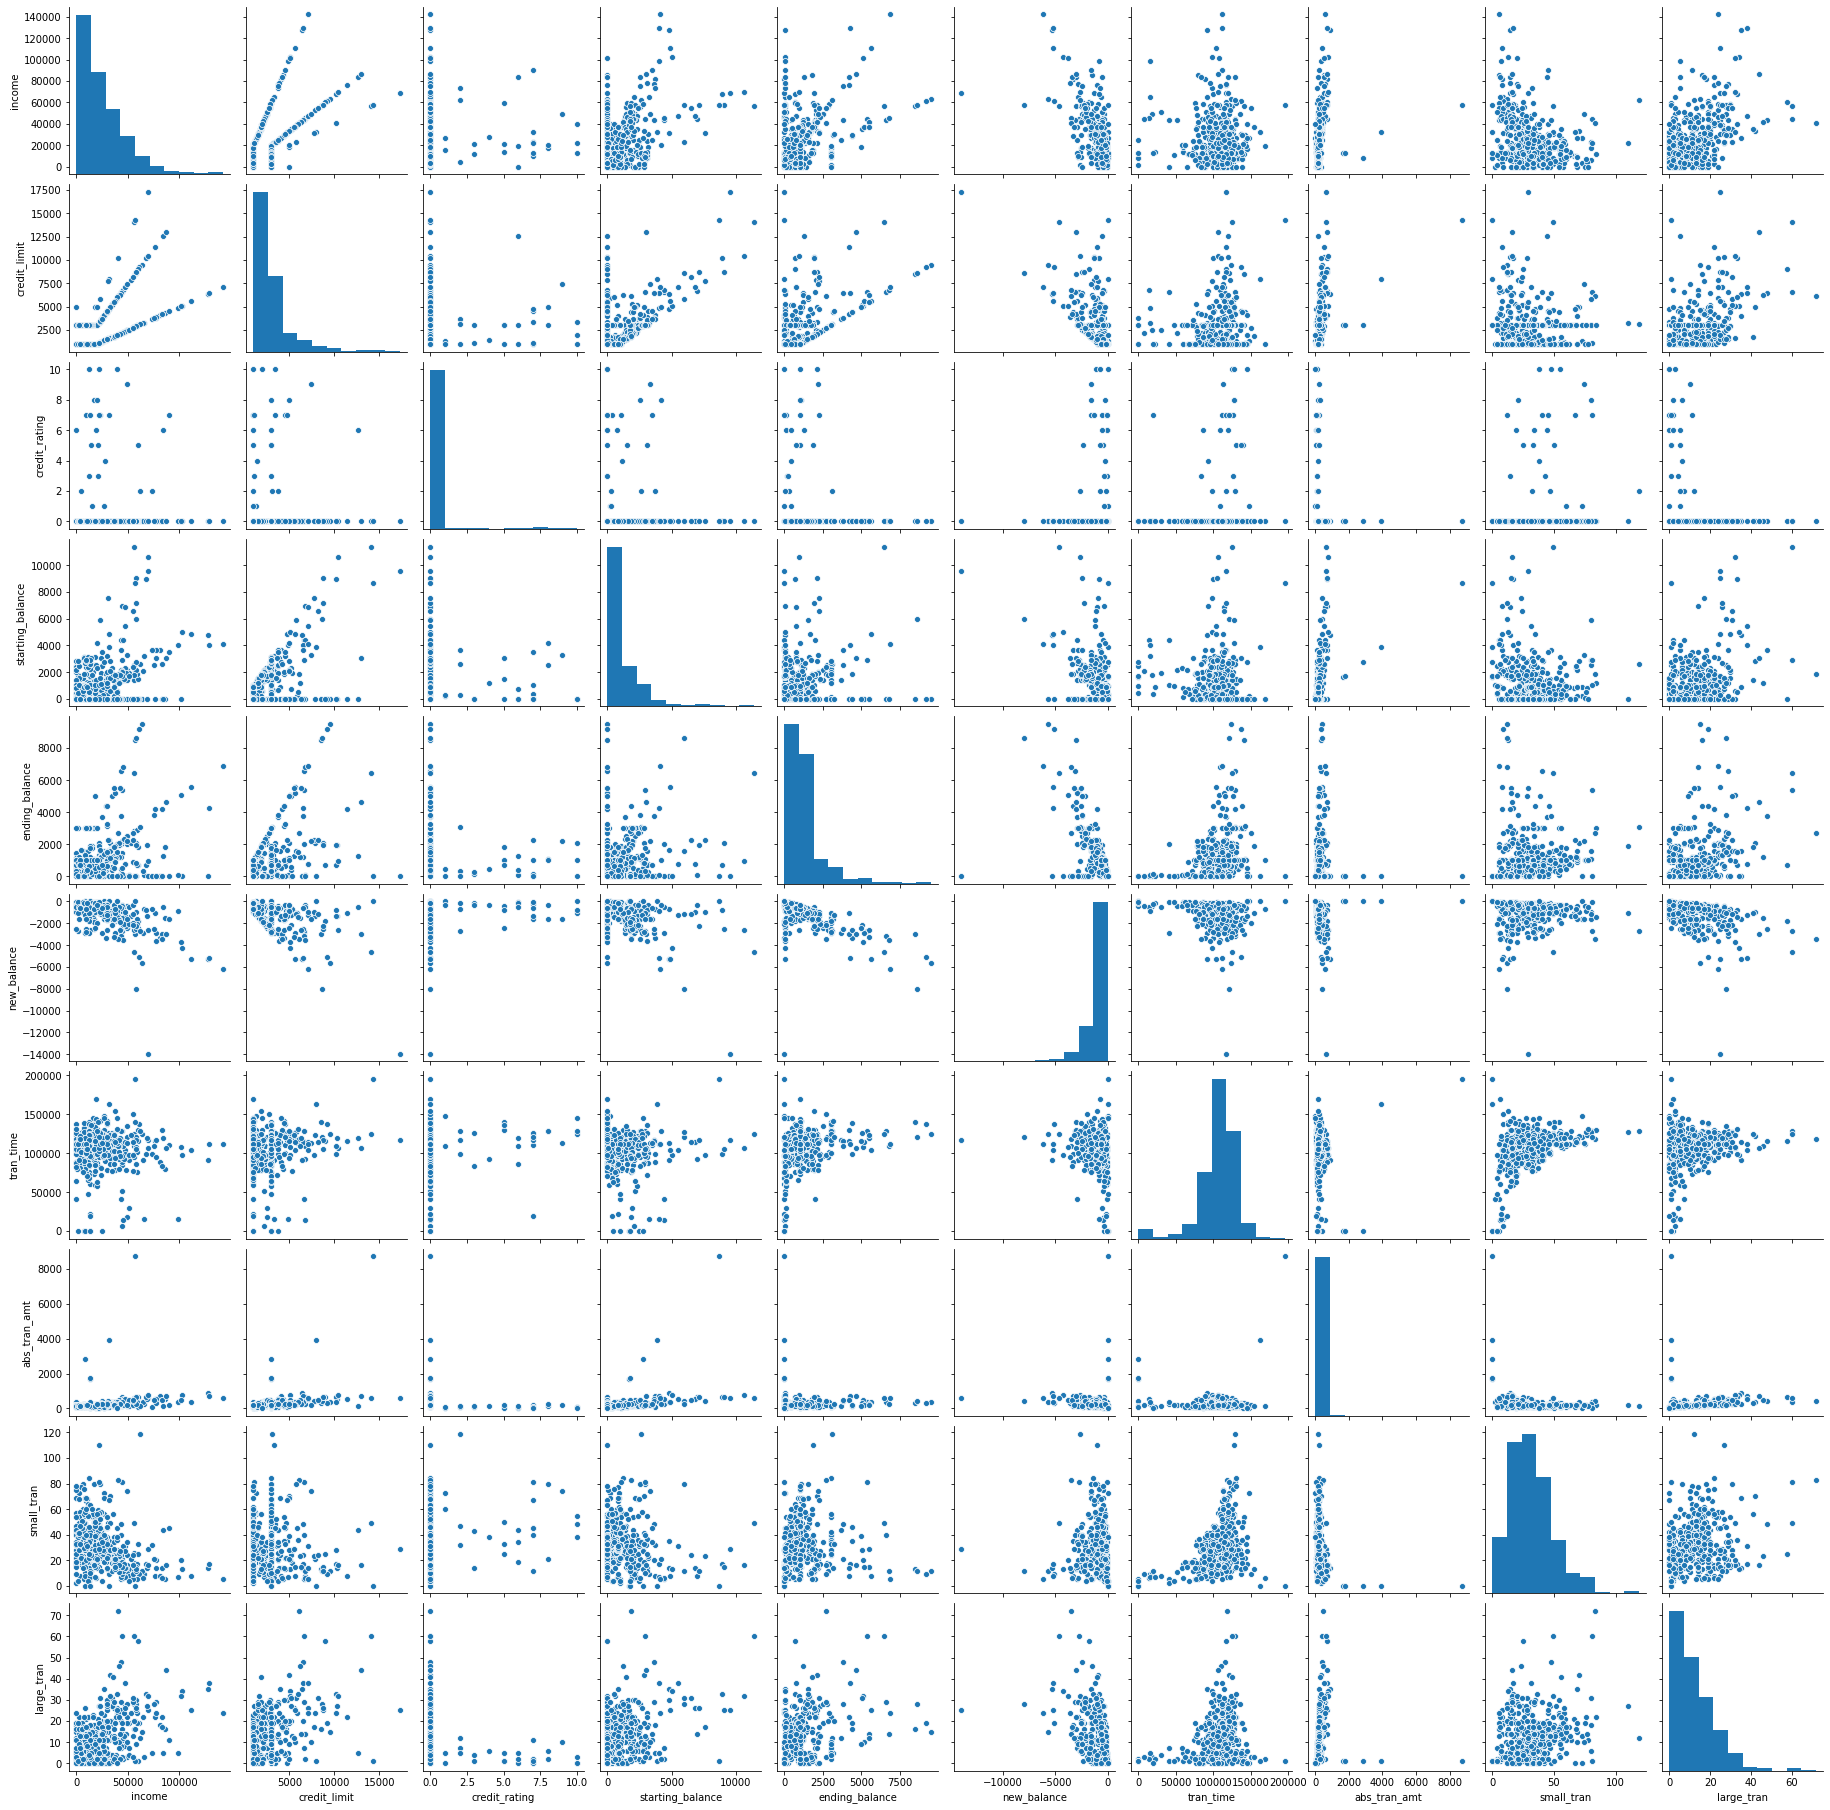

In [574]:
sns.pairplot(credit_regression)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.



<AxesSubplot:xlabel='large_tran'>

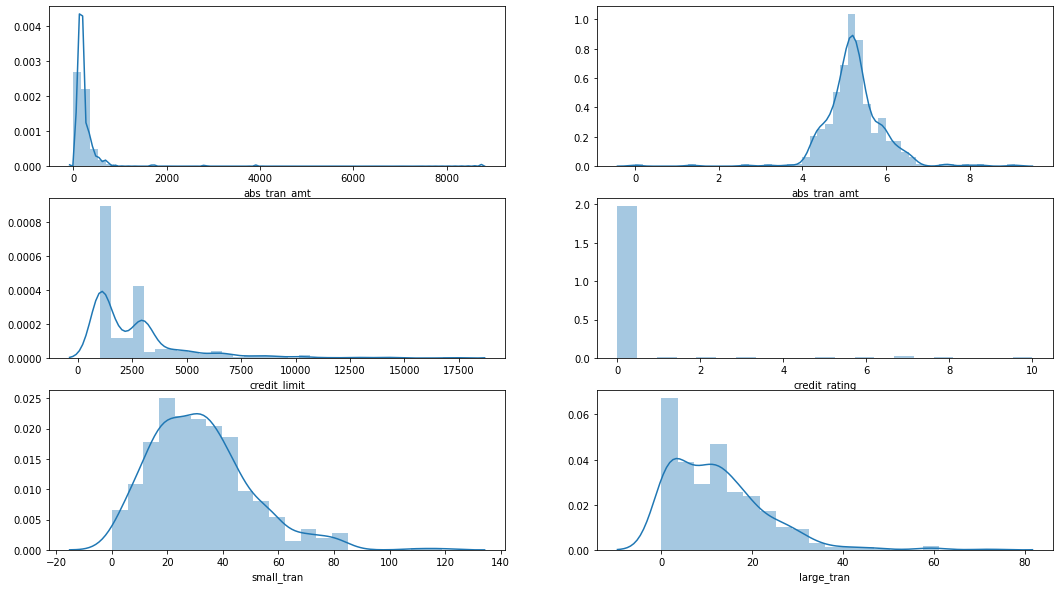

In [584]:
fig, ax = plt.subplots(3,2,figsize=(18,10))

sns.distplot((credit_regression['abs_tran_amt']), ax = ax[0][0])
sns.distplot(np.log(credit_regression['abs_tran_amt']+1), ax =ax[0][1])

sns.distplot((credit_regression['credit_limit']), ax = ax[1][0])
sns.distplot((credit_regression['credit_rating']), ax = ax[1][1])

sns.distplot((credit_regression['small_tran']), ax = ax[2][0])
sns.distplot((credit_regression['large_tran']), ax = ax[2][1])

In [614]:
credit_regression = credit_regression[credit_regression['new_balance'] > -6000]
credit_regression['log_tran_amt_+1'] = np.log(credit_regression['abs_tran_amt']+1)       

In [616]:
credit_regression.drop(['abs_tran_amt','credit_limit', 'credit_rating'], axis =1, inplace = True)  

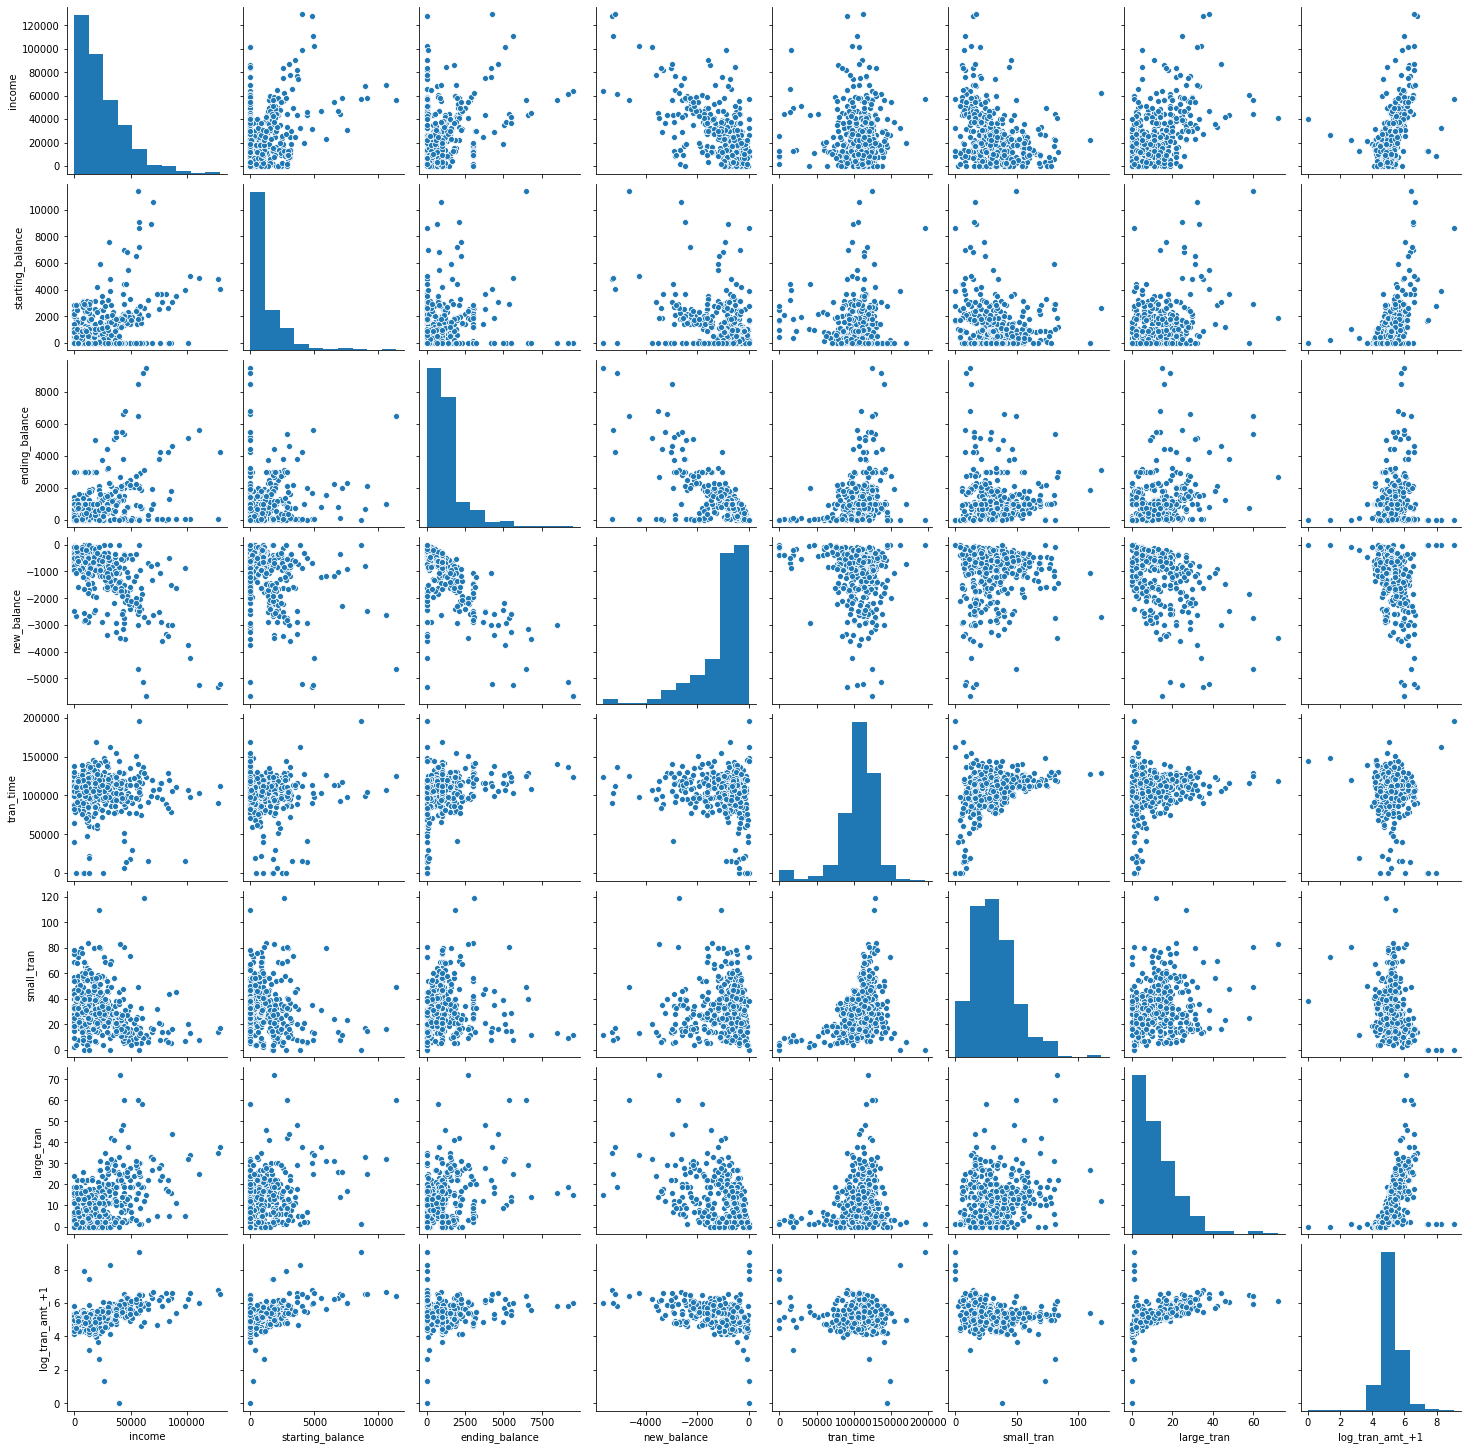

In [617]:
sns.pairplot(credit_regression)

<AxesSubplot:xlabel='ending_balance'>

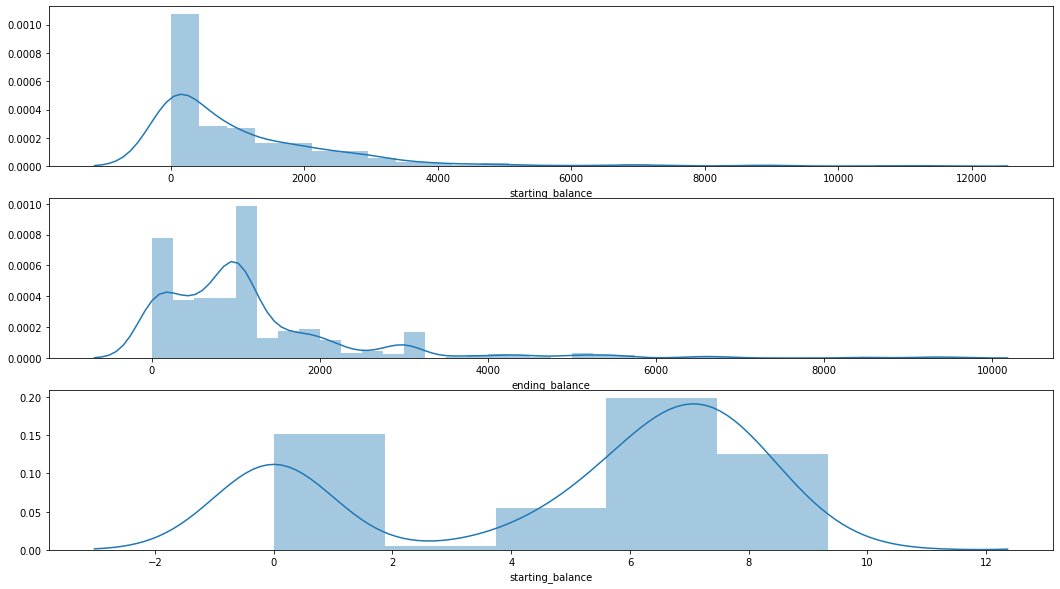

In [628]:
fig, ax = plt.subplots(3,figsize=(18,10))
sns.distplot(np.log(credit_regression['starting_balance']+1), ax = ax[2])
sns.distplot((credit_regression['starting_balance']), ax = ax[0])
sns.distplot((credit_regression['ending_balance']), ax =ax[1])

In [635]:
credit_regression.drop('ending_balance',axis = 1, inplace = True)

In [639]:
credit_regression.columns

Index(['income', 'starting_balance', 'new_balance', 'tran_time', 'small_tran',
       'large_tran', 'log_tran_amt_+1'],
      dtype='object')

In [643]:
credit_regression_x_scaled = pd.DataFrame(StandardScaler().fit_transform(credit_regression))
credit_regression_x_scaled.columns = ['income', 'starting_balance', 'new_balance', 'tran_time', 'small_tran','large_tran', 'log_tran_amt_+1']
credit_regression_x_scaled['income'] = credit_regression['income']
credit_regression_x_scaled

,income,starting_balance,new_balance,tran_time,small_tran,large_tran,log_tran_amt_+1
0,50890.0,0.311932,-1.352740,-0.624387,-1.055251,0.652028,0.517850
1,10053.0,0.103905,0.795429,0.717369,0.499676,0.176264,-0.010507
2,22690.0,-0.526850,0.346702,0.228857,1.443738,0.176264,-0.067699
3,6605.0,-0.705606,0.237226,0.654072,-0.222255,-0.775266,-0.299074
4,55888.0,0.222048,-1.527700,0.117722,-0.944185,0.747181,1.101453
...,...,...,...,...,...,...,...
449,3339.0,1.141528,-0.677982,-0.050439,0.444142,0.081111,0.235549
450,24815.0,-0.106592,0.386112,0.238955,1.554804,0.461722,-0.091864
451,9129.0,-0.156759,0.892066,-0.017101,-0.055655,-0.394654,-0.061696
452,9271.0,1.928598,0.770250,0.876750,-0.610986,-0.965572,0.422040


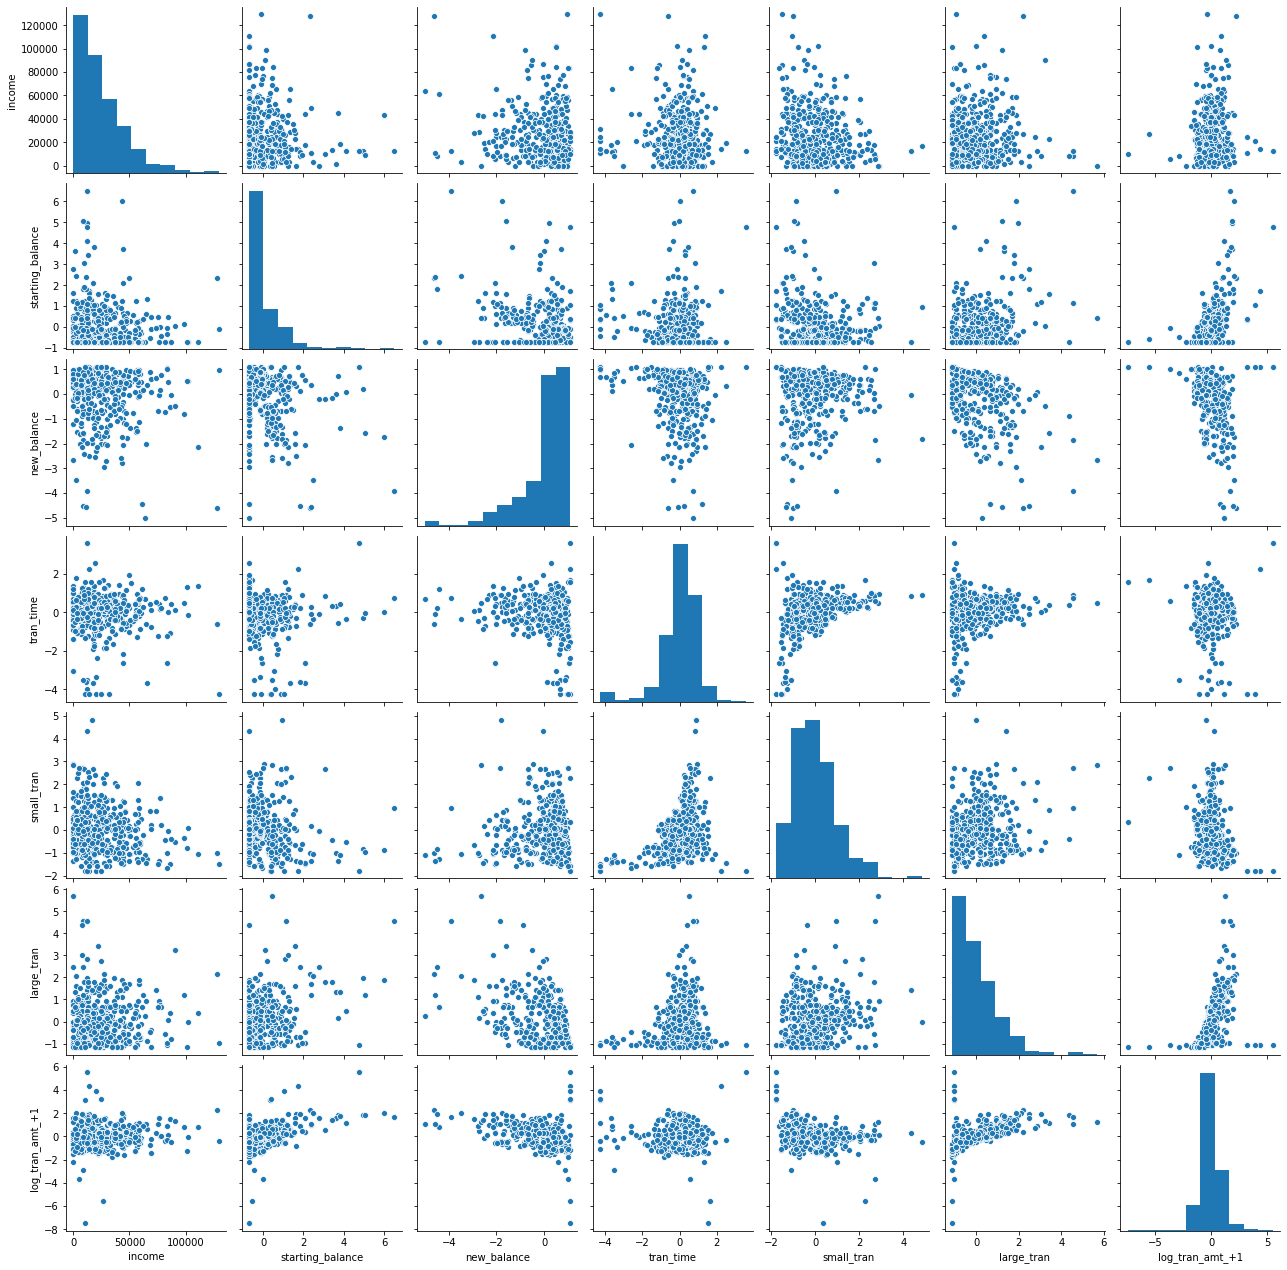

In [642]:
sns.pairplot(credit_regression_x_scaled)

In [652]:
credit_regression_scaled = pd.DataFrame(StandardScaler().fit_transform(credit_regression))
credit_regression_scaled.columns = ['income', 'starting_balance', 'new_balance', 'tran_time', 'small_tran','large_tran', 'log_tran_amt_+1']

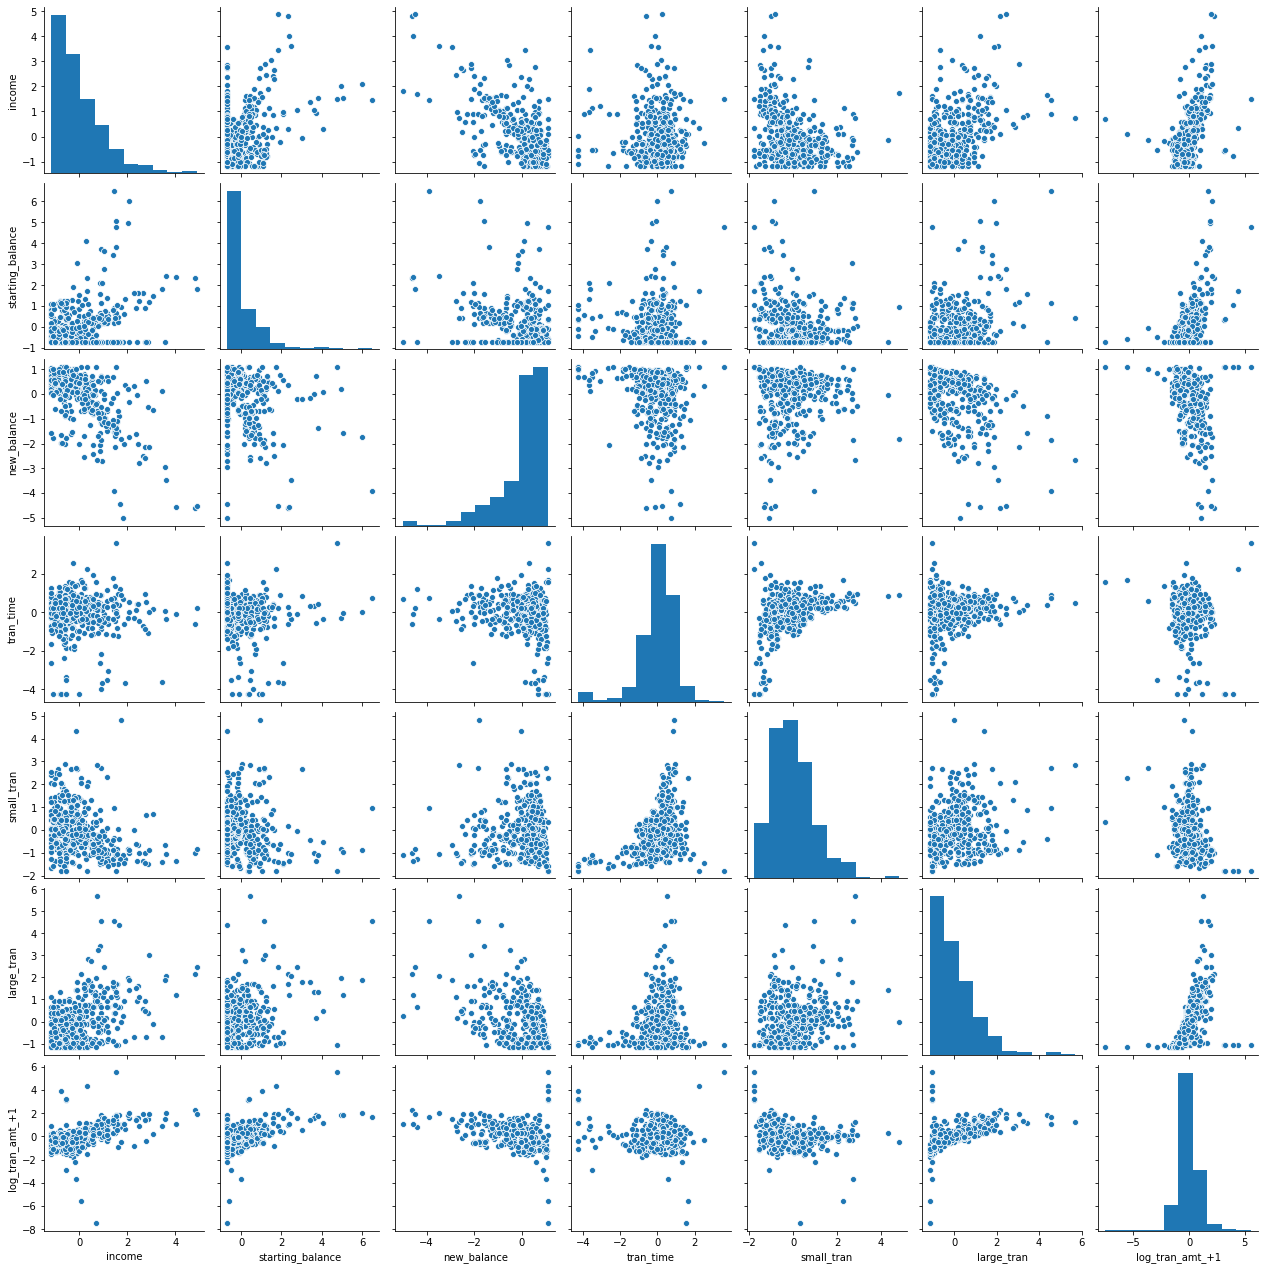

In [653]:
sns.pairplot(credit_regression_scaled)

<AxesSubplot:>

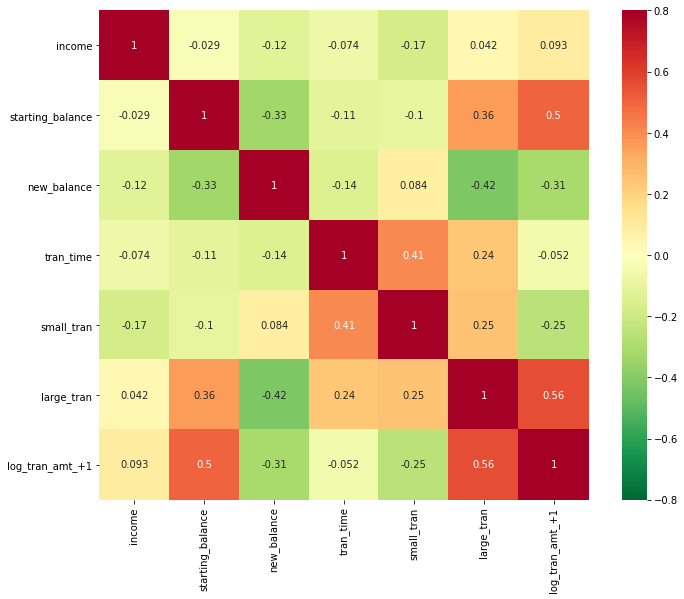

In [648]:
corrmat = credit_regression_x_scaled.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmin=-0.8,vmax=.8,annot = True, square=True,cmap="RdYlGn_r")

In [677]:
credit_regression_scaled.head()

,income,starting_balance,new_balance,tran_time,small_tran,large_tran,log_tran_amt_+1
0,1.219362,0.311932,-1.352740,-0.624387,-1.055251,0.652028,0.517850
1,-0.689706,0.103905,0.795429,0.717369,0.499676,0.176264,-0.010507
2,-0.098945,-0.526850,0.346702,0.228857,1.443738,0.176264,-0.067699
3,-0.850895,-0.705606,0.237226,0.654072,-0.222255,-0.775266,-0.299074
4,1.453011,0.222048,-1.527700,0.117722,-0.944185,0.747181,1.101453


In [678]:
y = credit_regression_scaled['income']
x = credit_regression_scaled.drop('income', axis = 1)

In [679]:
lin_reg = sm.OLS(y,x)
model = lin_reg.fit()
print_model = model.summary()
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 income   R-squared (uncentered):                   0.579
Model:                            OLS   Adj. R-squared (uncentered):              0.573
Method:                 Least Squares   F-statistic:                              102.6
Date:                Fri, 14 Aug 2020   Prob (F-statistic):                    6.88e-81
Time:                        13:38:57   Log-Likelihood:                         -447.97
No. Observations:                 454   AIC:                                      907.9
Df Residuals:                     448   BIC:                                      932.6
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
starting_balance     0.0963      0.037      2.616      0.009       0.024       0.169
new_balance         -0.4719      0.036    -13.198      0.000      -0.542      -0.402
tran_time           -0.0253      0.035     -0.723      0.470      -0.094       0.043
small_tran          -0.2973      0.039     -7.555      0.000      -0.375      -0.220
large_tran           0.2420      0.046      5.277      0.000       0.152       0.332
log_tran_amt_+1      0.0717      0.045      1.585      0.114      -0.017       0.161
==============================================================================
Omnibus:                      109.984   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              418.176
Skew:                           1.042   Prob(JB):                     1.56e-91
Kurtosis:                       7.214   Cond. No.                         3.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Gradient descent

In [706]:
credit_regression = pd.read_csv('credit_regression.csv') 
credit_regression.drop(['Unnamed: 0'], axis = 1, inplace = True)
credit_regression.head()

,income,credit_limit,credit_rating,starting_balance,ending_balance,new_balance,tran_time,abs_tran_amt,small_tran,large_tran
0,50890.0,2500.0,0.0,1607.40,20.00,-2270.140937,90762.718750,264.174375,13.0,19.0
1,10053.0,3000.0,0.0,1278.78,369.72,-274.873273,124236.781818,182.569636,41.0,14.0
2,22690.0,1100.0,0.0,282.38,1100.00,-691.661111,112049.388889,175.404861,58.0,14.0
3,6605.0,3000.0,0.0,0.00,1548.23,-793.345000,122657.656250,149.162813,28.0,4.0
4,55888.0,2800.0,0.0,1465.41,20.00,-2432.648000,109276.800000,397.074286,15.0,20.0


In [707]:
def predict_y(x,params):
    y_pred = np.zeros(x.shape[0])
    for i in range(len(x.columns)):
        y_pred = y_pred + x[x.columns[i]]*params[i]
    return(y_pred)

In [739]:
def grad(x, y, theta, iterations, alpha):
    X = copy.deepcopy(x)
    past_costs = []
    past_thetas = [theta]
    
    for i in range(iterations):
        prediction = predict_y(X,theta)
        error = prediction - y
        cost = 1/(2*m) * np.dot(error.T, error)
        past_costs.append(cost)
        theta = theta - (alpha * (1/m) * np.dot(X.T, error))
        past_thetas.append(theta)
    
    print('cost at last iteration:',cost)    
    return past_thetas, past_costs

### raw

In [740]:
alpha = 0.0001 
iterations = 100
m = y.size 
np.random.seed(0) 
theta = np.zeros(9) 

In [741]:
y = credit_regression['income']
x = credit_regression.drop('income', axis = 1)

In [742]:
past_thetas, past_costs = grad(x, y, theta, iterations, alpha)
theta = past_thetas[-1]

cost at last iteration: nan


In [743]:
theta

array([nan, nan, nan, nan, nan, nan, nan, nan, nan])

### scaled

In [750]:
alpha = 0.0001 
iterations = 100
m = y.size 
np.random.seed(0) 
theta = np.zeros(6) 

In [751]:
y = credit_regression_scaled['income']
x = credit_regression_scaled.drop('income', axis = 1)

In [752]:
past_thetas, past_costs = grad(x, y, theta, iterations, alpha)
theta = past_thetas[-1]

cost at last iteration: 0.48930646969843894


In [753]:
theta

array([ 0.00400297, -0.00643315, -0.00035746, -0.00311761,  0.00428442,
        0.00473154])

In [754]:
credit_regression_scaled.head()

,income,starting_balance,new_balance,tran_time,small_tran,large_tran,log_tran_amt_+1
0,1.219362,0.311932,-1.352740,-0.624387,-1.055251,0.652028,0.517850
1,-0.689706,0.103905,0.795429,0.717369,0.499676,0.176264,-0.010507
2,-0.098945,-0.526850,0.346702,0.228857,1.443738,0.176264,-0.067699
3,-0.850895,-0.705606,0.237226,0.654072,-0.222255,-0.775266,-0.299074
4,1.453011,0.222048,-1.527700,0.117722,-0.944185,0.747181,1.101453


In [756]:
SSE = sum((predict_y(x,theta) - y)**2)
SSE

444.1942474331426